In [1]:
import wandb

In [2]:
# pyyaml (yaml) :: parses configuration files (YAML files)
# see https://www.cloudbees.com/blog/yaml-tutorial-everything-you-need-get-started for more information on YAML files
import yaml 

# huggingface :: datasets : dataset-handling libraries from huggingface
from datasets import load_dataset
#from datasets.filesystems import S3FileSystem # for S3 interactions

# huggingface :: transformers : transformer, trainer and tokenizer objects for the actual training
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AutoTokenizer, AutoModelForCausalLM, DataCollatorForLanguageModeling, Trainer, TrainingArguments

# transformer_imports.py :: contains all our transformer imports and the MODEL DICT
from transformers import TrainingArguments, Trainer, DataCollatorForLanguageModeling

# pytorch (torch) :: machine learning and deep learning method library
import torch

/home/ubuntu/anaconda3/envs/torch_p37/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import os
import time
import datetime
import pandas as pd
import seaborn as sns
import numpy as np
import random

import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)

from transformers import GPT2LMHeadModel, GPT2Tokenizer, GPT2Config, GPT2LMHeadModel
from transformers import AdamW, get_linear_schedule_with_warmup

In [4]:
# nltk punkt sentence tokenizer, divides text into a list of sentences
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/ubuntu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
!nvidia-smi

Mon Mar 27 18:15:36 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:00:1E.0 Off |                    0 |
| N/A   36C    P8    14W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
path_to_config = "../configs/gpt2-refl-27-mar-2023.yaml"

In [7]:
# open yaml config as a strema and load into config_dict
with open(path_to_config, "r") as stream:
    try:
        config_dict = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print("Configuration load failed!")
        print(exc)

In [8]:
df = pd.read_csv(config_dict["data_train_path"])
df_val = pd.read_csv(config_dict["data_validation_path"])

In [9]:
df.dropna(inplace=True)  # drop NA values
triplets = df.triplet.copy()  # copy over triplets

In [10]:
val_triplets = df_val.triplet.copy()  # validation triplets

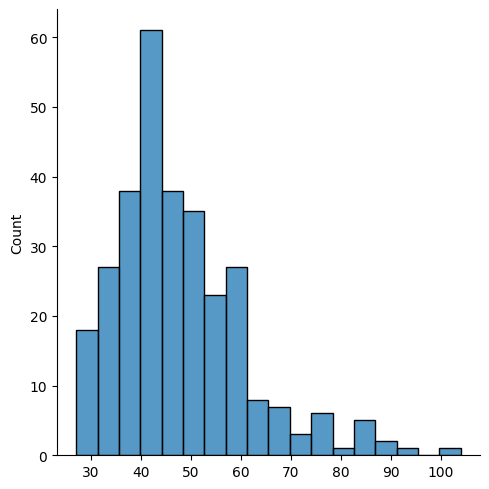

In [11]:
# how long is our training data?
doc_lengths = []
for triplet in triplets:
    tokens = nltk.word_tokenize(triplet)
    doc_lengths.append(len(tokens))
doc_lengths = np.asarray(doc_lengths)
sns.displot(doc_lengths)

In [12]:
np.average(doc_lengths)
# on average, we have ~47.5 tokens per entry, a good thing for GPT2 embedding size of 768 in gpt-small

47.57807308970099

In [13]:
model_name = config_dict['model_name']
hyperparameters = config_dict['training_settings']['hyperparameters']

In [14]:
# load gpt-2 tokenizer
tokenizer = GPT2Tokenizer.from_pretrained(model_name, bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [15]:
print("The max model length is {} for this model, although the actual embedding size for GPT small is 768".format(tokenizer.model_max_length))
print("The beginning of sequence token {} token has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.bos_token_id), tokenizer.bos_token_id))
print("The end of sequence token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.eos_token_id), tokenizer.eos_token_id))
print("The padding token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.pad_token_id), tokenizer.pad_token_id))

The max model length is 1024 for this model, although the actual embedding size for GPT small is 768
The beginning of sequence token <|startoftext|> token has the id 50257
The end of sequence token <|endoftext|> has the id 50256
The padding token <|pad|> has the id 50258


In [16]:
# amount of examples passed through model before a backwards pass
batch_size = hyperparameters['batch_size']

In [17]:
class GPT2Dataset(Dataset):
    # Inherits Dataset from PyTorch, a data primitive which
    # stores samples and corresponding labels
    # custom Dataset needs init, len, and getitem
    # init runs once when instantiating Dataset object
    def __init__(self, txt_list, tokenzier, gpt2_type='gpt2-xl', max_length=1024):
        self.tokenizer = tokenizer,
        self.input_ids = []
        self.attn_masks = []
        
        # for each text list, encode it using tokenizer then unpacl encodings dict into:
        # input_ids: numerical representations of our tokens
        # attn_masks: indicates which tokens should be attended to (and which are pads)
        for txt in txt_list:
            # tokenize the txt with a custom start and end token
            # encodings dict contains both our token input ids and attention mask
            # truncation will clip sentences that are too long
            # padding adds pad tokens until we reach max input sentence length 768
            encodings_dict = tokenizer('<|startoftext|>'+ txt + '<|endoftext|>', truncation=True, max_length=max_length, padding="max_length")
            
            self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
            self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))
    # overrides len() to returns the number of samples in our dataset
    def __len__(self):
        return len(self.input_ids)
    # loads and returns a sample from dataset at given index idx
    # sometimes we need to do type swapping in getitem, but not here
    def __getitem__(self, idx):
        return self.input_ids[idx], self.attn_masks[idx]
            

In [18]:
train_dataset = GPT2Dataset(triplets, tokenizer, max_length=1024)
val_dataset = GPT2Dataset(val_triplets, tokenizer, max_length=1024)

In [19]:
print(f"{len(train_dataset)} Training Samples")
print(f"{len(val_dataset)} Validation Samples")

301 Training Samples
34 Validation Samples


In [20]:
# Create DataLoader for training and validation datasets
# PyTorch DataLoaders wrap iterable around a Dataset to access samples easily
# We typically pass in minibatches and reshuffle data at epochs to reduce overfitting
# DataLoaders leverage python's multiprocessing to speed up data retrieval

# take training samples in random order
train_dataloader = DataLoader(train_dataset,
                              sampler=RandomSampler(train_dataset),
                              batch_size=batch_size)

# For validation, the order doesn't matter, so we read sequentially
validation_dataloader = DataLoader(val_dataset,
                                   sampler=SequentialSampler(val_dataset),
                                   batch_size=batch_size)

In [21]:
# config to instantiate model
configuration = GPT2Config.from_pretrained(model_name, output_hidden_states=False)


In [22]:
# instantiate model
model = GPT2LMHeadModel.from_pretrained(model_name, config=configuration)


In [23]:
# resize token embeddings for our custom tokens (e.g. bos_token)
model.resize_token_embeddings(len(tokenizer))

Embedding(50259, 768)

In [24]:
device = torch.device("cuda")

In [25]:
# sends model to current device - in this case CUDA
model.cuda()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50259, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dro

In [26]:
# Set the seed value
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [27]:
wandb.init(
  project="gpt2-reflector",
  notes="Hyperparameters found with sweep, final train -> push to HF",
  tags=["gpt2", "reflector"],
)

wandb: Currently logged in as: andrewbrown. Use `wandb login --relogin` to force relogin
time="2023-03-27T18:16:17Z" level=fatal msg="Failed to discover neuron devices" error="Unable to read device information from the driver. Make sure aws-neuron-dkms is installed and the neuron driver is accessible."


In [28]:
# all the below set the corresponding values from the configuration file config.yaml:
model_name = config_dict["model_name"]
pretrained = config_dict["pretrained"]
data_train_path = config_dict["data_train_path"]
data_validation_path = config_dict["data_validation_path"]


output_data_dir = config_dict["output_data_dir"] + "/"
output_model_dir = config_dict["output_model_dir"] + "/"

hyperparameters = config_dict["training_settings"]["hyperparameters"]
hyperparameters["learning_rate"] = float(hyperparameters["learning_rate"])
hyperparameters["weight_decay"] = float(hyperparameters["weight_decay"])

deepspeed_config = config_dict["training_settings"]["deepspeed_settings"]

In [29]:
hyperparameters

{'find_hyperparams_automatically': False,
 'num_trials': 10,
 'fp16': True,
 'deepspeed': True,
 'grad_accumulation_steps': 2,
 'eval_batch_size': 1,
 'learning_rate': 0.050793350306270954,
 'epochs': 10,
 'warmup_steps': 100,
 'epsilon': '1e-7',
 'batch_size': 3,
 'sample_every': 100,
 'seed': 42,
 'eval_steps': 10,
 'weight_decay': 0.01}

In [30]:
learning_rate = hyperparameters['learning_rate']
epsilon = float(hyperparameters['epsilon'])  # epsilon must be a float, not str
epochs = hyperparameters['epochs']
warmup_steps = float(hyperparameters['warmup_steps'])
sample_every = float(hyperparameters['sample_every'])

In [31]:
wandb.config.update(config_dict)

In [32]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon
                )

/home/ubuntu/anaconda3/envs/torch_p37/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [33]:
# Total num training steps is [num batches] x [num epochs]
# (not the same number as num training sample)
total_steps = len(train_dataloader) * epochs

In [34]:
# Create learning rate scheduler
# we schedule learning rate using 
# optimzer, num_warmup steps, and num_training steps
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=warmup_steps,
                                            num_training_steps=total_steps)

In [35]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

In [70]:
# start global timer
total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in range(0, epochs):
    """
    Training Loop
    """
    wandb.watch(model)
    print(f"---Epoch {epoch_i + 1} of {epochs}---")
    print("---Training...---")
    
    # start epoch timer
    t0 = time.time()
    
    total_train_loss = 0

    # sets model into train mode, not actual backprop
    # dropout and batchnorm behave differently
    # opposite of model.eval() for inference mode
    model.train()
    
    for step, batch in enumerate(train_dataloader):
        # grab input tokens, labels, and masks
        input_tokens = batch[0].to(device)
        # in this case, we're generating text,
        # so label tokens are the input tokens shifted
        label_tokens = batch[0].to(device)
        attn_masks = batch[1].to(device)
        
        # clear any gradients from model tensors
        # prevents any gradient accumulation
        model.zero_grad()
        
        # forward pass
        outputs = model(input_tokens,
                        labels=label_tokens,
                        attention_mask=attn_masks,
                        token_type_ids=None
                       )
        
        # grab loss from outputs
        loss = outputs[0]
        
        batch_loss = loss.item()  # detach from device with item
        total_train_loss += batch_loss
        
        # get sample every x batches
        if step % sample_every == 0 and not step == 0:
            # calculate elapsed time and print statistics
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))
            
            # set model to inference mode for testing
            model.eval()
            
            # sample model with generate() using no tokens, just let it generate
            sample_outputs = model.generate(bos_token_id=random.randint(1,30000),
                                            do_sample=True,
                                            top_k=50,
                                            max_length=200,
                                            top_p=0.95,
                                            num_return_sequences=1
                                           )
            
            for i, sample_output in enumerate(sample_outputs):
                out = tokenizer.decode(sample_output, skip_special_tokens=True)
                print(f"{i}: {out}")
            
            # back to train mode
        
        # backpropagation step
        # computes dloss/dx for every parameter x which has requires_grad=True.
        # updates gradient values
        # x.grad += dloss/dx
        loss.backward()
        
        # step optimizer
        # updates the value of x using the gradient x.grad
        # x += -lr * x.grad
        optimizer.step()
        
        # step scheduler
        # tells scheduler to increase learning rate
        # using our warmup steps
        scheduler.step()
        
    print("---Done Training Epoch!---")
    # calculate average loss over all batches
    avg_train_loss = total_train_loss / len(train_dataloader)
    
    # measure how long the epoch took
    training_time = format_time(time.time() - t0)
    
    print(f"---Average training loss {avg_train_loss} ---")
    print(f"---Training epoch took {training_time} ---")
    
    """
    Validation
    """
    print("---Running Validation...---")
    
    # start batch timer
    t0 = time.time()
    
    # set model to inference mode
    model.eval()
    
    total_eval_loss = 0
    nb_eval_steps = 0
    
    # evaluate data for one epoch
    for batch in validation_dataloader:
        # grab input tokens, labels, and masks
        input_tokens = batch[0].to(device)
        # in this case, we're generating text,
        # so label tokens are the input tokens shifted
        label_tokens = batch[0].to(device)
        attn_masks = batch[1].to(device)
        
        # freeze gradients
        with torch.no_grad():
            outputs = model(input_tokens,
                            attention_mask=attn_masks,
                            labels=label_tokens)
            
            loss = outputs[0]
        
        batch_loss = loss.item()
        total_eval_loss += batch_loss
        
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    validation_time = format_time(time.time() - t0)
    
    print(f"Validation Loss: {avg_val_loss}")
    print(f"Validation took: {validation_time}")
    
    # save all training statistics from the epoch
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Validation Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        })
    # log training data to wandb as well
    wandb.log({
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Validation Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        })
    

print("---Training Complete!")
print(f"---Total training time took {format_time(time.time()-total_t0)}")


---Epoch 1 of 10---
---Training...---


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    101. Loss: 0.044084250926971436.   Elapsed: 0:01:32.
0:  SahPrompt: What will it look like when you have made this change in your smoking habit?
Response: You will be better will save money, your health will save lung capacity will be proud of smoking

---Done Training Epoch!---
---Average training loss 0.07224507286849588 ---
---Training epoch took 0:01:32 ---
---Running Validation...---
Validation Loss: 0.11735399936636288
Validation took: 0:00:03
---Epoch 2 of 10---
---Training...---


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    101. Loss: 0.10192755609750748.   Elapsed: 0:01:33.
0:  BryanPrompt: What will it look like when you have made this change in your smoking habit?
Response: I think my sense of course
Reflection: You believe you know your body.

---Done Training Epoch!---
---Average training loss 0.07240249688672547 ---
---Training epoch took 0:01:34 ---
---Running Validation...---
Validation Loss: 0.11735399936636288
Validation took: 0:00:03
---Epoch 3 of 10---
---Training...---


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    101. Loss: 0.06638983637094498.   Elapsed: 0:01:37.
0:  spiritsPrompt: Now, what is the thing you like least about smoking?
Response: bad in social aspect and smell of everything, especially a result of everything and clothes
Reflection: Smoking are concerned about the nicotine pleas of smoking.

---Done Training Epoch!---
---Average training loss 0.07227583969067229 ---
---Training epoch took 0:01:38 ---
---Running Validation...---
Validation Loss: 0.11735399936636288
Validation took: 0:00:04
---Epoch 4 of 10---
---Training...---


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    101. Loss: 0.10952933877706528.   Elapsed: 0:01:41.
0:  seesPrompt: Now, what is one thing about your smoking habit that you would like to change?
Response: Maybe I smoke less
Reflection: You realize that you smoke in social settings.

---Done Training Epoch!---
---Average training loss 0.0724144362392697 ---
---Training epoch took 0:01:42 ---
---Running Validation...---
Validation Loss: 0.11735399936636288
Validation took: 0:00:04
---Epoch 5 of 10---
---Training...---


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    101. Loss: 0.01346272137016058.   Elapsed: 0:01:41.
0:  hungryPrompt: To start, what is the thing you like most about smoking?
Response: It
Reflection: Tobacco cigarettes takes scent of smoking helps you feel

---Done Training Epoch!---
---Average training loss 0.0718280670352944 ---
---Training epoch took 0:01:41 ---
---Running Validation...---
Validation Loss: 0.11735399936636288
Validation took: 0:00:04
---Epoch 6 of 10---
---Training...---


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    101. Loss: 0.05865932255983353.   Elapsed: 0:01:41.
0:  PTPrompt: What will it look like when you have made this change in your smoking habit?
Response: I will feel money, and the smell that once a better.
Reflection: You believe you pass by smoking has.

---Done Training Epoch!---
---Average training loss 0.07208412122165803 ---
---Training epoch took 0:01:41 ---
---Running Validation...---
Validation Loss: 0.11735399936636288
Validation took: 0:00:04
---Epoch 7 of 10---
---Training...---


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    101. Loss: 0.06326639652252197.   Elapsed: 0:01:41.
0: üPrompt: To start, what is the thing you like most about smoking?
Response: the feeling on smoking helps you inhale causing me and use my parents and calm.
Reflection: Smoking habit.

---Done Training Epoch!---
---Average training loss 0.07254588135545796 ---
---Training epoch took 0:01:41 ---
---Running Validation...---
Validation Loss: 0.11735399936636288
Validation took: 0:00:04
---Epoch 8 of 10---
---Training...---


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    101. Loss: 0.11286480724811554.   Elapsed: 0:01:41.
0: rucePrompt: Now, what is the thing you like least about smoking?
Response: The smell and your feeling on your clothes.
Reflection: You dislike how how time for your body and smoking makes that smoking makes you can kill you worry about a taste.

---Done Training Epoch!---
---Average training loss 0.07285531730123676 ---
---Training epoch took 0:01:41 ---
---Running Validation...---
Validation Loss: 0.11735399936636288
Validation took: 0:00:04
---Epoch 9 of 10---
---Training...---


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    101. Loss: 0.0852726548910141.   Elapsed: 0:01:41.
0:  derivativesPrompt: Finally, what are the steps you need to take to make this change?
Response: I need to Stop smoking in order to quit when im other activities to make a conscious down. I'm you smoke, been a professional to quit smoking. 
Reflection: You realize that. You need to make to commit to decision of moments around smoking. You are strategies to make your bought to deal to you a concious with and trigger that smoking patch
---Done Training Epoch!---
---Average training loss 0.07260414164992843 ---
---Training epoch took 0:01:43 ---
---Running Validation...---
Validation Loss: 0.11735399936636288
Validation took: 0:00:04
---Epoch 10 of 10---
---Training...---


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    101. Loss: 0.09342725574970245.   Elapsed: 0:01:41.
0: Prompt: Finally, what are the steps you need to take to make this change?
Response: i need to go to finally stop smoking less and try to manage a lot gradually mechanism.
Reflection: You realize that making this change and you want to have resistance to make a pack on being harm better and try more situations also have willpower and smoke.

---Done Training Epoch!---
---Average training loss 0.07230837820190014 ---
---Training epoch took 0:01:42 ---
---Running Validation...---
Validation Loss: 0.11735399936636288
Validation took: 0:00:04
---Training Complete!
---Total training time took 0:17:13


In [71]:
# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Validation Loss,Training Time,Validation Time
epoch,,,,
1,0.07,0.12,0:01:32,0:00:03
2,0.07,0.12,0:01:34,0:00:03
3,0.07,0.12,0:01:38,0:00:04
4,0.07,0.12,0:01:42,0:00:04
5,0.07,0.12,0:01:41,0:00:04
6,0.07,0.12,0:01:41,0:00:04
7,0.07,0.12,0:01:41,0:00:04
8,0.07,0.12,0:01:41,0:00:04
9,0.07,0.12,0:01:43,0:00:04


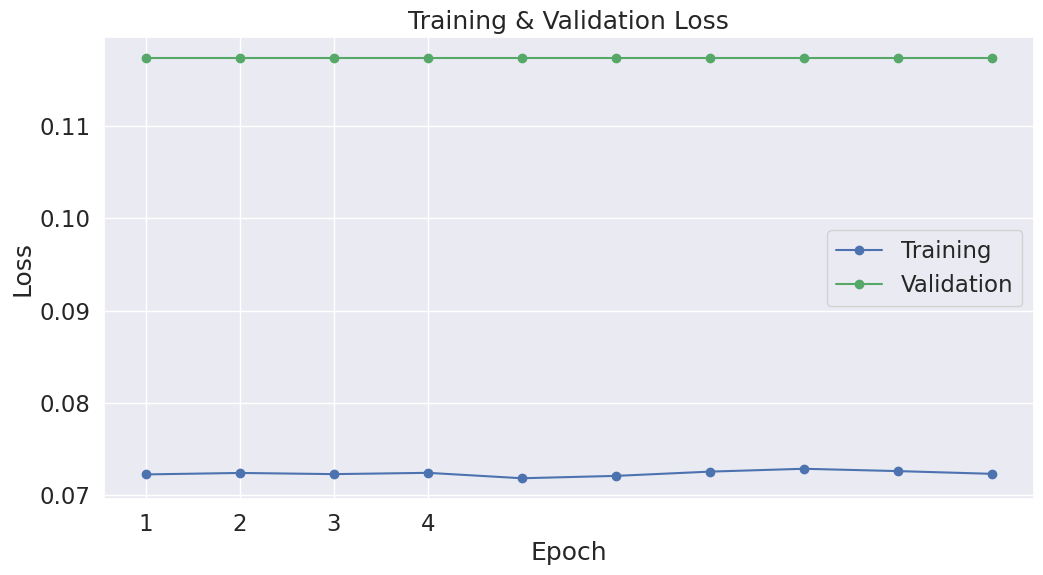

In [72]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Validation Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [40]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The GPT-2 model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:2]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[2:14]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The GPT-2 model has 148 different named parameters.

==== Embedding Layer ====

transformer.wte.weight                                  (50259, 768)
transformer.wpe.weight                                   (1024, 768)

==== First Transformer ====

transformer.h.0.ln_1.weight                                   (768,)
transformer.h.0.ln_1.bias                                     (768,)
transformer.h.0.attn.c_attn.weight                       (768, 2304)
transformer.h.0.attn.c_attn.bias                             (2304,)
transformer.h.0.attn.c_proj.weight                        (768, 768)
transformer.h.0.attn.c_proj.bias                              (768,)
transformer.h.0.ln_2.weight                                   (768,)
transformer.h.0.ln_2.bias                                     (768,)
transformer.h.0.mlp.c_fc.weight                          (768, 3072)
transformer.h.0.mlp.c_fc.bias                                (3072,)
transformer.h.0.mlp.c_proj.weight                        (3072

In [41]:
def inference_reflector(model, path_to_data, config_dict):
    # import the data we are inferencing reflector with
    # set of incomplete reflections which offer a good understanding of the reflector
    df = pd.read_csv(path_to_data)
    
    # set model to inference mode for testing
    model.eval()
    
    # de-nest yaml config
    generation_config = config_dict['refgen']

    for index, row in df.iterrows():
        # sample model with generate() using no tokens, just let it generate
        sample_outputs = model.generate(bos_token_id=random.randint(1,30000),
                                        temperature = config['temperature'],
                                        # flag to use a sampling technique or greedy
                                        do_sample=config['do_sample'],
                                        # penalize model for duplicating words
                                        repetition_penalty = config['repetition_penalty'],
                                        # of proposed words, only select from top k of them
                                        top_k=config['top_k'],
                                        # max amount of tokens to generate
                                        max_length=config['max_length'],
                                        # of propsed words, select from the words that add up to top_p value
                                        # e.g. top_p=0.26 x(0.15),y(0.1),z(0.05)
                                        # only select from x and y (0.15+0.1+0.05=0.3 which is too high)
                                        top_p=config['top_p'],
                                        # num of independently computed returned sequences for each element in the batch.
                                        num_return_sequences=config['num_return_sequences']
                                       )
    
        # after sampling model, decode tokens and print
        for i, sample_output in enumerate(sample_outputs):
            out = tokenizer.decode(sample_output, skip_special_tokens=True)
            print(f"===========================")
            print(f"{i}: {out}")
            print(f"===========================")
            
            

In [65]:
device

device(type='cuda')

In [80]:
model.eval()
generation_config = config_dict['refgen']
config = config_dict

text = "Prompt: What is the thing you like most about smoking?\nResponse: I love the headrush I get from smoking.\n"

# encode the input text into tokens using the tokenizer
tokenized_text = tokenizer.encode(
    text, return_tensors="pt", padding=True, truncation=True
)
encodings_dict = tokenizer('<|startoftext|>'+ text + '<|endoftext|>', truncation=True, max_length=1024, padding="max_length")

input_ids = torch.tensor(encodings_dict['input_ids'])
input_ids = tokenized_text.to(device)

# sample model with generate() using no tokens, just let it generate
with torch.no_grad():
    sample_outputs = model.generate(input_ids,
                                    bos_token_id=random.randint(1,30000),
                                    temperature = 0.8,
                                    # flag to use a sampling technique or greedy
                                    do_sample=generation_config['do_sample'],
                                    # penalize model for duplicating words
                                    repetition_penalty = 1.1,
                                    # of proposed words, only select from top k of them
                                    top_k=generation_config['top_k'],
                                    # max amount of tokens to generate
                                    max_length=1024,
                                    # of propsed words, select from the words that add up to top_p value
                                    # e.g. top_p=0.26 x(0.15),y(0.1),z(0.05)
                                    # only select from x and y (0.15+0.1+0.05=0.3 which is too high)
                                    top_p=generation_config['top_p'],
                                    # num of independently computed returned sequences for each element in the batch.
                                    num_return_sequences=1
                                   )
    output = tokenizer.decode(sample_outputs[0], skip_special_tokens=True)
    print(output)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Prompt: What is the thing you like most about smoking?
Response: I love the headrush I get from smoking.
Reflection: You dislike the need to smoking can have made to replace smoking but you can help if you you smoke and you at other anxiety.



In [89]:
# saving and loading the finetuned model
output_dir = '../models/gpt2-mi-reflector/'
tokenizer_dir = '../models/gpt2-mi-reflector/'

# create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# create output directory if needed
if not os.path.exists(tokenizer_dir):
    os.makedirs(tokenizer_dir)
    
    
print(f"Saving model to {output_dir}")

Saving model to ../models/gpt2-mi-reflector/


In [90]:
# Save trained model, configuration and tokenizer
model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(tokenizer_dir)

('../models/gpt2-mi-reflector/tokenizer_config.json',
 '../models/gpt2-mi-reflector/special_tokens_map.json',
 '../models/gpt2-mi-reflector/vocab.json',
 '../models/gpt2-mi-reflector/merges.txt',
 '../models/gpt2-mi-reflector/added_tokens.json')

In [91]:
# save training arguments with trained model
torch.save(model.state_dict(), os.path.join(output_dir, 'training_args.bin'))

In [ ]:
# # Load a trained model and vocabulary that you have fine-tuned
model = GPT2LMHeadModel.from_pretrained(output_dir)
tokenizer = GPT2Tokenizer.from_pretrained(output_dir)
model.to(device)